In [15]:
%load_ext autoreload
%autoreload 2

import sys
import os
import yaml
import ctypes

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

from tqdm import tqdm

from forward_model import forward, weight_map_w_redshift

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.system("cd ~/CosMomentum/cpp_code; make DSS")
lib = ctypes.CDLL("/home/guerrini/CosMomentum/cpp_code/DSS.so")

g++ -std=c++0x  -L/usr/local/lib/ -I/usr/local/include -shared -o DSS.so -fPIC python_interfaces.cpp -lgsl -lgslcblas -pthread -O3 -Wuninitialized


In file included from GalaxySample.h:58,
                 from GalaxySample3D.h:3,
                 from python_interfaces.cpp:9:
GalaxySample.cpp: In member function ‘std::vector<double> GalaxySample::return_CIC_from_matter_density_PDF(double, std::vector<std::vector<double> >)’:
GalaxySample.cpp:264:67: warning: ‘delta_g’ may be used uninitialized in this function [-Wmaybe-uninitialized]
       P_of_N_given_delta[n][d] = this->return_P_of_N_given_delta_g(n, N_bar, PDF_data[0][d], delta_g);
                                  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from FlatInhomogeneousUniverseLCDM.h:221,
                 from python_interfaces.cpp:8:
FlatInhomogeneousUniverseLCDM.cpp: In member function ‘std::vector<std::vector<double> > FlatInhomogeneousUniverseLCDM::compute_phi_tilde_of_lambda_2D(double, double, double, double)’:
FlatInhomogeneousUniverseLCDM.cpp:1247:18: warning: ‘dskew_L_RL_dR’ may be used uninitialized in this functio

In [3]:
with open('../config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
# Perform the forward model
path_sims = config['simulation']['path_simulation']
path_info = config['simulation']['path_info']
sim_idx = config['simulation']['sim_number']
sim_name = config['simulation']['sim_name']
ray_tracing_method = config['ray_tracing']['method']
nside = config['preprocessing']['nside']
nside_intermediate = config['preprocessing'].get('nside_intermediate', None)

verbose = True if config['verbose'] == 'T' else False

kappa_lensing, gamma_lensing, overdensity_array, z_bin_edges, cosmo_params = forward(
        path_sims, path_info, sim_name=sim_name, sim_number=sim_idx, nside=nside, nside_intermediate=nside_intermediate, method=ray_tracing_method, verbose=verbose
)

[!] Preprocessing the Gower Street simulation 1...
[!] Reading the cosmological parameters...
[!] Done in 2.63 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 1...


100it [01:42,  1.03s/it]


[!] Done in 1.72 min.
[!] Number of redshift shells: 77
[!] Larger redshift: 2.07237
[!] Performing the ray tracing using GLASS...


100%|██████████| 77/77 [00:00<00:00, 137.12it/s]


[!] Converting convergence map to shear maps with lmax=1024...


100%|██████████| 77/77 [01:15<00:00,  1.02it/s]


In [5]:
def get_beam(theta, lmax):
    def top_hat(b, radius):
        return np.where(abs(b) <= radius, 1 / (np.cos(radius) - 1) / (-2 * np.pi), 0)
    t = theta * np.pi / (60 * 180)
    b = np.linspace(0.0, t * 1.2, 10000)
    bw = top_hat(b, t)
    ### plotting the filter
    # plt.plot(b, bw)
    beam = hp.sphtfunc.beam2bl(bw, b, lmax)
    return beam
def smooth_map(args):
    theta, lmax, kappa, nside = args
    beam = get_beam(theta, lmax)
    almkappa = hp.sphtfunc.map2alm(kappa)
    kappa_smooth = hp.sphtfunc.alm2map(hp.sphtfunc.almxfl(almkappa, beam), nside)
    return kappa_smooth

In [6]:
#CosMomentum

#initialising a new universe and its matter content
a_initial = 0.000025
a_final = 1.0

initialise_new_Universe = lib.initialise_new_Universe
initialise_new_Universe.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
initialise_new_Universe.restype = None

Omfid = cosmo_params['Omega_m'][0]
Obfid = cosmo_params['Omega_b'][0]
hfid = cosmo_params['h'][0]
nsfid = cosmo_params['n_s'][0]
sig8fid = cosmo_params['sigma_8'][0]
wfid = cosmo_params['w'][0]



z = 1.0

initialise_new_Universe(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, wfid, 0.0)

NOTE: in FlatHomogeneousUniverseLCDM::set_initial_conditions(): initial conditions module assumes flat universe!
WARNING in FlatInhomogeneousUniverseLCDM::set_initial_conditions(): growth factor is computed for matter density fluctuations and all other components are assumed to be homogeneous!
Setting sphere variances.


Setting cylinder variances.
Setting spherical collapse evolution.
Setting cylindrical collapse evolution.
Done.


In [7]:
return_Ndelta = lib.return_Ndelta
return_Ndelta.argtypes = []
return_Ndelta.restype = ctypes.c_int
N_delta = return_Ndelta()
return_Ndelta.restype = ctypes.c_int
N_delta = return_Ndelta()

return_convergence_PDF_from_single_z = lib.return_convergence_PDF_from_single_z
# return_convergence_PDF_from_single_z          (                   double* kappa_values,                                      double* PDF,        double z, double theta_in_arcmin,     double f_NL, double var_NL_rescale, int index_of_universe)
return_convergence_PDF_from_single_z.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_double,        ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_convergence_PDF_from_single_z.restype = None

return_convergence_PDF_from_source_sample = lib.return_convergence_PDF_from_source_sample
# return_convergence_PDF_from_source_sample          (                   double* kappa_values,                                      double* PDF, double theta_in_arcmin,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_convergence_PDF_from_source_sample.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta),        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_convergence_PDF_from_source_sample.restype = None

## This function returns the probability distribution function (PDF) of the cosmic shear convergence
# - from sources at redshift z
# - top-hat smoothing radius theta [arcmin]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def convergence_PDF_at_single_z(z, theta, f_NL, var_NL_rescale, index_of_universe):
    kappa_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_convergence_PDF_from_single_z(ctypes.byref(kappa_values), ctypes.byref(PDF_values), z, theta, f_NL, var_NL_rescale, index_of_universe)
    return np.array(kappa_values), np.array(PDF_values)


## This function returns the probability distribution function (PDF) of the cosmic shear convergence
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
# - top-hat smoothing radius theta [arcmin]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
def convergence_PDF_from_source_sample(theta, f_NL, var_NL_rescale, index_of_galaxy_sample):
    kappa_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_convergence_PDF_from_source_sample(ctypes.byref(kappa_values), ctypes.byref(PDF_values), theta, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(kappa_values), np.array(PDF_values)

In [8]:
z = 1.0
theta = 20.0
f_NL = 0.0 # if you want f_NL != 0 , you need to compute initial Bispectrum first
           # (see e.g. set_primordial_skewness_from_eps3_powerlaw_approximation_2D above)
var_NL_rescale = 1.0
index_of_universe = 0
kappa_values_single_z, PDF_values_single_z = convergence_PDF_at_single_z(z, theta, f_NL, var_NL_rescale, index_of_universe)

Computing projected phi_data:
computing CGF grid & cutting out 1st branch
projecting CGF
delta_min = -0.0337695
delta_max = 0.0124437
Computing CGF_data done.
Done.
Computing tau coefficients:
Done.
Computing PDF:
Done.                          


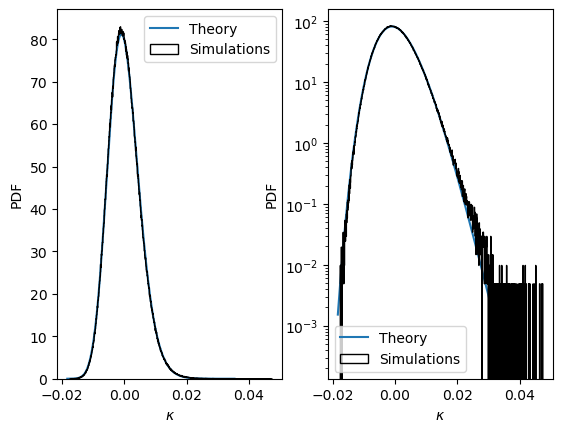

In [9]:
plt.figure()

plt.subplot(121)

plt.plot(kappa_values_single_z, PDF_values_single_z, label='Theory')

#Smooth kappa map
nside = 512
lmax = 2*nside
theta = 20.0
args = (theta, lmax, kappa_lensing[57], nside)

kappa_smooth = smooth_map(args)

plt.hist(kappa_smooth, bins=1000, histtype='step', density=True, color='k', label='Simulations')
plt.xlabel(r'$\kappa$')
plt.ylabel('PDF')
plt.legend()

plt.subplot(122)


plt.plot(kappa_values_single_z, PDF_values_single_z, label='Theory')

#Smooth kappa map
nside = 512
lmax = 2*nside
theta = 20.0
args = (theta, lmax, kappa_lensing[57], nside)

kappa_smooth = smooth_map(args)

plt.hist(kappa_smooth, bins=1000, histtype='step', density=True, color='k', label='Simulations')
plt.xlabel(r'$\kappa$')
plt.ylabel('PDF')
plt.legend()
plt.yscale('log')

plt.show()

In [10]:
add_projected_galaxy_sample = lib.add_projected_galaxy_sample
# add_projected_galaxy_sample          (int index_of_universe, const char *n_of_z_file, double density_in_1_over_arcminSq,        double b1,        double b2,       double a0,       double a1, int bias_model)
add_projected_galaxy_sample.argtypes = [         ctypes.c_int,         ctypes.c_char_p,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double,   ctypes.c_int]
add_projected_galaxy_sample.restype = None

In [139]:
# Creating projected galaxy sample
bias_model = 0
density_sample_1 = 0.
b1_sample_1 = 1.6
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.28
n_of_z_file_str = '/home/guerrini/UNIONS_forward_model/data_utils/dndz_bin_4.txt'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, bias_model)

EULERIAN bias model.


In [150]:
index_of_galaxy_sample = 5
theta = 20
kappa_values_from_sample_0, PDF_values_from_sample_0 = convergence_PDF_from_source_sample(theta, f_NL, var_NL_rescale, index_of_galaxy_sample)

Computing projected phi_data:
computing CGF grid & cutting out 1st branch
projecting CGF
delta_min = -0.0536086
delta_max = 0.019605
Computing CGF_data done.
Done.
Computing tau coefficients:
Done.
Computing PDF:
Done.                           


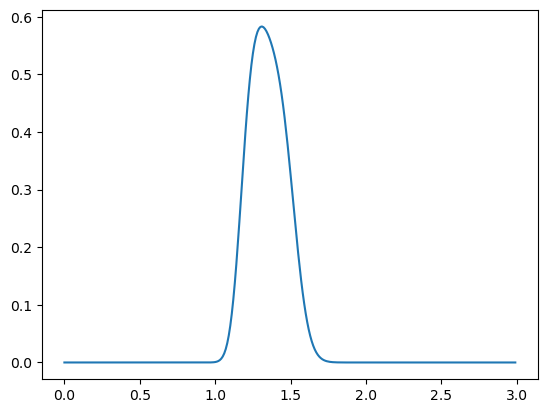

In [138]:
#Get average map
#Load n(z) file
redshift_distr = np.loadtxt('/home/guerrini/UNIONS_forward_model/data_utils/dndz.txt')


plt.figure()

plt.plot(redshift_distr[:, 0], redshift_distr[:, 4])
plt.show()

to_save = np.array([redshift_distr[:, 0], redshift_distr[:, 4]]).T
np.savetxt('/home/guerrini/UNIONS_forward_model/data_utils/dndz_bin_4.txt', to_save)


In [151]:
kappa_bar = weight_map_w_redshift(kappa_lensing, z_bin_edges ,(redshift_distr[:, 4], redshift_distr[:, 0]))
kappa_bar -= np.mean(kappa_bar)

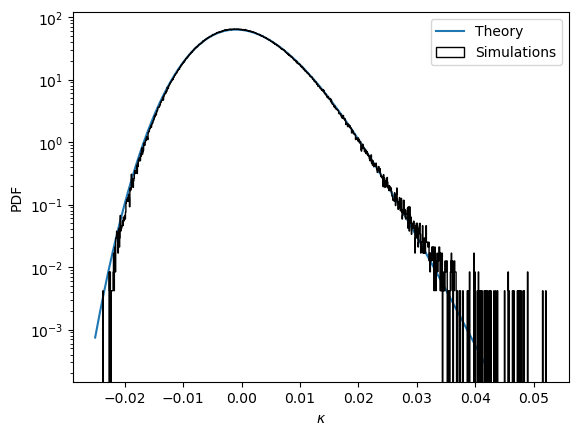

In [152]:
plt.figure()

plt.plot(kappa_values_from_sample_0, PDF_values_from_sample_0, label='Theory')

kappa_smooth_bar = smooth_map((theta, lmax, kappa_bar, nside))

plt.hist(kappa_smooth_bar, bins=1000, histtype='step', density=True, color='k', label='Simulations')

plt.xlabel(r'$\kappa$')
plt.ylabel('PDF')
plt.yscale('log')
plt.legend()


plt.show()

In [153]:
step = kappa_values_from_sample_0[1] - kappa_values_from_sample_0[0]
start = kappa_values_from_sample_0[0] - step/2
end = kappa_values_from_sample_0[-1] + step/2

bin_edges = np.linspace(start, end, len(kappa_values_from_sample_0)+1)

In [154]:
hist_kappa_bar, bins_kappa_bar = np.histogram(kappa_smooth_bar, bins=bin_edges, density=True)

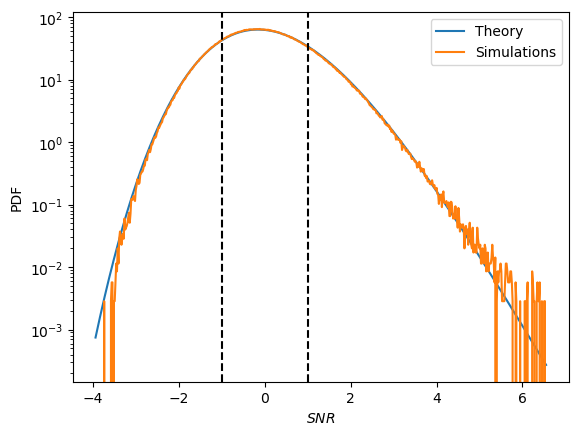

In [155]:
plt.figure()

plt.plot(kappa_values_from_sample_0/np.std(kappa_smooth_bar), PDF_values_from_sample_0, label='Theory')
plt.plot(bins_kappa_bar[:-1]/np.std(kappa_smooth_bar), hist_kappa_bar, label='Simulations')

plt.axvline(-1, color='k', linestyle='--')
plt.axvline(1, color='k', linestyle='--')

plt.xlabel(r'$SNR$')
plt.ylabel('PDF')
plt.yscale('log')

plt.legend()

plt.show()

In [156]:
residuals = (PDF_values_from_sample_0 - hist_kappa_bar)/PDF_values_from_sample_0

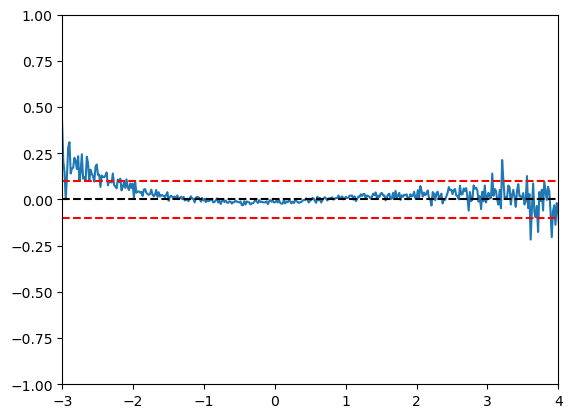

In [157]:
plt.figure()

plt.plot(kappa_values_from_sample_0/np.std(kappa_smooth_bar), residuals)
plt.axhline(0, color='k', linestyle='--')

plt.axhline(0.1, color='r', linestyle='--')
plt.axhline(-0.1, color='r', linestyle='--')
plt.xlim(-3, 4)
plt.ylim(-1, 1)

plt.show()